## Initial exploratory data analysis

In [15]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys,os,os.path as osp, getopt
#import cPickle as cp
from itertools import combinations as combs
from functools import partial
#from sklearn.cross_validation import KFold,LeaveOneOut,StratifiedKFold
from scoop import futures
from glob import glob
from collections import defaultdict
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import torch
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR

## Load Data

Eliminate duplicates

In [16]:
# Load Data
data = pd.read_csv('Human_Expression_EvoRates.txt', sep = '\t')

# Eliminate null data
data = data.loc[~data['Ka_Mouse'].isnull()]

# Prepare data
X = np.array(np.log10(data.drop(columns=['id', 'id_symbol', 'Ka_Mouse'])+1e-4))
X = (X - X.mean(axis=0, keepdims=True)) / X.std(axis=0, keepdims=True)
y = np.array(np.log10(data['Ka_Mouse']))
y = (y - y.mean()) / y.std()

# Tissues
tissues = data.drop(columns=['id', 'id_symbol', 'Ka_Mouse']).columns

# Split dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## E-R anticorrelation

Example of the negative correlation between gene expression and protein evolutionary rate using transcriptomic measurements from the brain's hippocampus

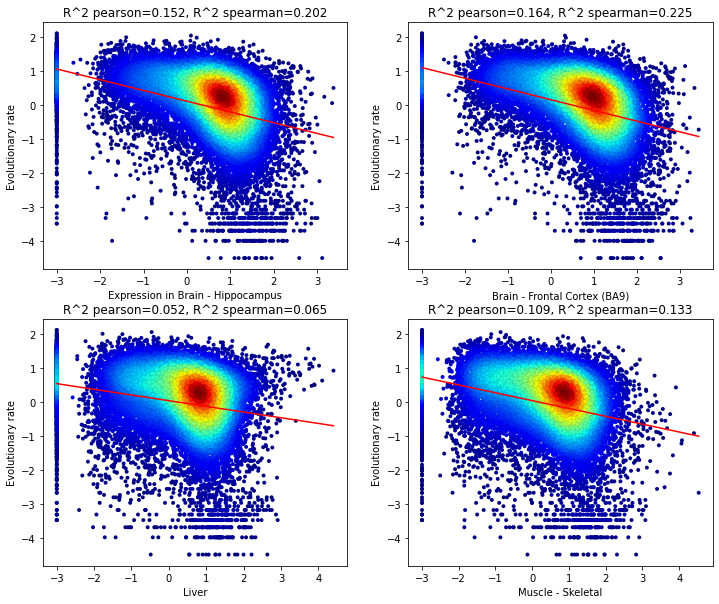

In [17]:
# Example scatter plots

x1 = data['Brain - Hippocampus']
x2 = data['Brain - Frontal Cortex (BA9)']
x3 = data['Liver']
x4 = data['Muscle - Skeletal']
x1_log = np.log10(x1+1e-3)
x2_log = np.log10(x2+1e-3)
x3_log = np.log10(x3+1e-3)
x4_log = np.log10(x4+1e-3)

plt.rcParams['figure.figsize'] = [12, 10]
x_logs = [x1_log, x2_log, x3_log, x4_log]
x_labels = ['Expression in Brain - Hippocampus', 'Brain - Frontal Cortex (BA9)', 'Liver', 'Muscle - Skeletal']

fig, axs = plt.subplots(2, 2)

for i in range(len(axs.flat)):
    R_p,_ = scipy.stats.pearsonr(x_logs[i], y)
    R_sp,_ = scipy.stats.spearmanr(x_logs[i], y)
    ax = axs.flat[i]
    xy = np.vstack([x_logs[i], y])
    z = gaussian_kde(xy)(xy)
    ax.scatter(x_logs[i], y, c=z, s=15, cmap = 'jet', edgecolors = 'black', linewidths = 0.05)
    m, b = np.polyfit(x_logs[i], y, 1)
    ax.plot(np.arange(min(x_logs[i]),max(x_logs[i]),0.001), m*np.arange(min(x_logs[i]),max(x_logs[i]),0.001) + b, 'r')
    ax = axs.flat[i]
    ax.set(xlabel=x_labels[i], ylabel='Evolutionary rate')
    ax.set_title("R^2 pearson=%.3f, R^2 spearman=%.3f" % (R_p**2, R_sp**2))

    
plt.savefig('./figures/er_tissues.png')

## PCA

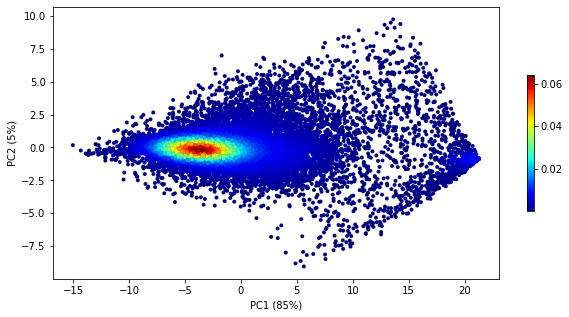

In [18]:
# Singular value decomposition
u, s, vh = np.linalg.svd(X)

# Project data in first two PCs 
df_pca = pd.DataFrame({"pc1" : vh[0,:], "pc2" : vh[1,:]})
new_data = np.matmul(X, vh[0:2,:].T)

# Plot
plt.rcParams['figure.figsize'] = [10, 5]
xy = np.vstack([new_data[:,0], new_data[:,1]])
z = gaussian_kde(xy)(xy)
plt.scatter(x=new_data[:,0], y=new_data[:,1], c=z, s=15, cmap = 'jet', edgecolors = 'black', linewidths = 0.05)
plt.colorbar(shrink = 0.5)
plt.ylabel('PC2 (5%)')
plt.xlabel('PC1 (85%)')
plt.savefig('./figures/pca_expression.png')

## Scree plot

Text(0, 0.5, 'Proportion of variance')

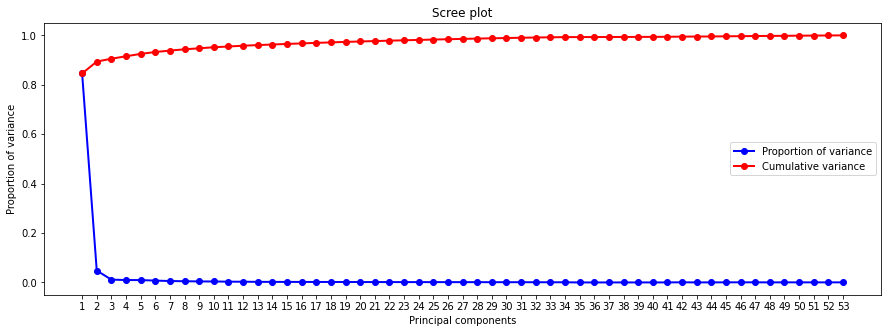

In [19]:
# Covariance matrix
Z = np.dot(X.T, X)

# Get eigenvectors and eigenvalues
eig_val, eig_vec = np.linalg.eig(Z)
D = np.diag(eig_val)
P = eig_vec

# Projection
Z_new = np.dot(Z, P)

# Proportion of variance explained by each feature
sum_eigval = np.sum(eig_val)
prop_var = [i/sum_eigval for i in eig_val]

# Cumulative variance
cum_var = [np.sum(prop_var[:i+1]) for i in range(len(prop_var))]

# Plot scree plot from PCA
x_labels = ['{}'.format(i+1) for i in range(len(prop_var))]
plt.rcParams['figure.figsize'] = [15, 5]
plt.plot(x_labels, prop_var, marker='o', markersize=6, color='blue', linewidth=2, label='Proportion of variance')
plt.plot(x_labels, cum_var, marker='o', color='red', linewidth=2, label="Cumulative variance")
plt.legend()
plt.title('Scree plot')
plt.xlabel('Principal components')
plt.ylabel('Proportion of variance')

## Simple correlations

Calculate regression coefficients for every tissue

In [4]:
# Calculate simple linear regressions for every tissue
pearson_cors = []
spearman_cors = []

for tissue_idx in range(len(tissues)):
    
    # Select expression data
    x = X[:,tissue_idx]
    
    # Figure parameters
    plt.rcParams['figure.figsize'] = [12, 10]
    
    # Calculate correlation
    R_p,_ = scipy.stats.pearsonr(x, y)
    R_sp,_ = scipy.stats.spearmanr(x, y)
    pearson_cors.append(R_p)
    spearman_cors.append(R_sp)
    
    # Calculate the point density
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    plt.scatter(x, y, c=z, s=15, cmap = 'jet', edgecolors = 'black', linewidths = 0.05)
    plt.colorbar(shrink = 0.5)
    m, b = np.polyfit(x, y, 1)
    plt.plot(np.arange(min(x),max(x),0.001), m*np.arange(min(x),max(x),0.001) + b, 'r')
    plt.ylabel('Evolutionary rate')
    plt.xlabel('Expression in '+tissues[tissue_idx])
    plt.title("R^2 pearson=%.3f, R^2 spearman=%.3f" % (R_p**2, R_sp**2))
    plt.savefig('./figures/linear_regression/'+str(tissue_idx)+'.png')
    plt.clf()


<Figure size 864x720 with 0 Axes>

Create a dataframe and sort tissues according to the maximum spearman and pearson R2

In [5]:
data_simple_cor = pd.DataFrame({'tissues':tissues, 'pearson R':pearson_cors, 'spearman R':spearman_cors, 
                                'pearson R2':np.array(pearson_cors)**2, 'spearman R2':np.array(spearman_cors)**2})
data_simple_cor.sort_values(by=['spearman R2', 'pearson R2'], ascending=False)

,tissues,pearson R,spearman R,pearson R2,spearman R2
13,Brain - Frontal Cortex (BA9),-0.383115,-0.474271,0.146777,0.224933
8,Brain - Anterior cingulate cortex (BA24),-0.378619,-0.465667,0.143352,0.216846
12,Brain - Cortex,-0.373390,-0.460084,0.139420,0.211677
16,Brain - Nucleus accumbens (basal ganglia),-0.371577,-0.453194,0.138069,0.205385
7,Brain - Amygdala,-0.373367,-0.452308,0.139403,0.204582
14,Brain - Hippocampus,-0.369212,-0.449260,0.136317,0.201834
15,Brain - Hypothalamus,-0.372274,-0.447710,0.138588,0.200444
9,Brain - Caudate (basal ganglia),-0.365968,-0.447558,0.133932,0.200308
10,Brain - Cerebellar Hemisphere,-0.368757,-0.443457,0.135982,0.196654
17,Brain - Putamen (basal ganglia),-0.365023,-0.442474,0.133241,0.195783


## Multiple Linear Regression

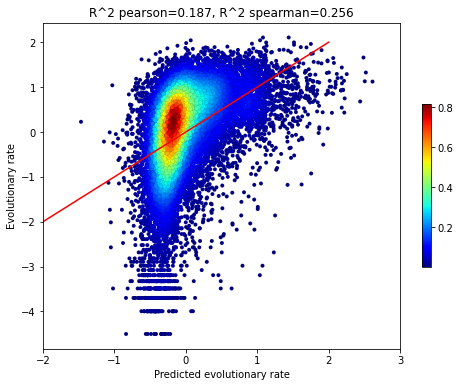

In [60]:
# Multiple linear regression
regr = LinearRegression()
regr.fit(X, y)
fitted_y = regr.predict(X)

# Figure parameters
plt.rcParams['figure.figsize'] = [8, 6]
    
# Calculate correlation
R_p,_ = scipy.stats.pearsonr(fitted_y, y)
R_sp,_ = scipy.stats.spearmanr(fitted_y, y)
    
# Calculate the point density
xy = np.vstack([fitted_y, y])
z = gaussian_kde(xy)(xy)
plt.scatter(fitted_y, y, c=z, s=15, cmap = 'jet', edgecolors = 'black', linewidths = 0.05)
plt.colorbar(shrink = 0.5)
plt.plot([-4, 2], [-4, 2], 'r')
plt.xlim((-2,3))
plt.ylabel('Evolutionary rate')
plt.xlabel('Predicted evolutionary rate')
plt.title("R^2 pearson=%.3f, R^2 spearman=%.3f" % (R_p**2, R_sp**2))
plt.savefig('./figures/multiple_linear_regression.png')


In [70]:
data_multiple_cor = pd.DataFrame({'tissue':tissues, 'coefficient':regr.coef_})
data_multiple_cor.sort_values(by=['coefficient'], ascending=True)

,tissue,coefficient
13,Brain - Frontal Cortex (BA9),-0.452952
5,Artery - Tibial,-0.216607
10,Brain - Cerebellar Hemisphere,-0.215425
37,Muscle - Skeletal,-0.168428
23,Cervix - Ectocervix,-0.168197
15,Brain - Hypothalamus,-0.161366
43,Skin - Not Sun Exposed (Suprapubic),-0.123437
25,Colon - Sigmoid,-0.104636
16,Brain - Nucleus accumbens (basal ganglia),-0.096195
22,Cells - Transformed fibroblasts,-0.094747


## K Nearest Neighbour 

Find the best number of neighbors and the best score

In [7]:
# Create new a knn model
knn = KNeighborsRegressor()

# Create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1,50)}

# Use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn, param_grid, cv=5)

# Fit model to data
knn_gscv.fit(X_train, y_train)

# Top n_neighbors value
best_n_neighbors = knn_gscv.best_params_
print(best_n_neighbors)

# R2 for the top performing value of n_neighbors
print(knn_gscv.best_score_)


{'n_neighbors': 37}
0.25152839264113797


Cross validation of predictions with the best parameter for number of neighbors

In [8]:
# Create a new KNN model
knn_cv = KNeighborsRegressor(best_n_neighbors['n_neighbors'])

# Train model with cv of 10
cv_scores = cross_val_score(knn_cv, X_train, y_train, cv=10)

# Average CV R2
print(np.mean(cv_scores))

0.2498940921406104


Fit a model with the training data and evaluate the performance in the testing data

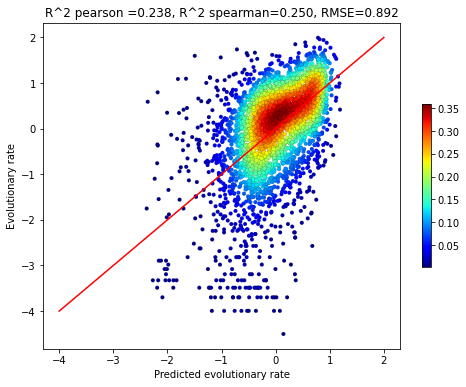

In [9]:
# Fit the classifier to the data
knn = KNeighborsRegressor(best_n_neighbors['n_neighbors'])
y_ = knn.fit(X_train, y_train)

# Predict test data
pred_knn = knn.predict(X_test)

# Calculate correlation
R_p,_ = scipy.stats.pearsonr(pred_knn, y_test)
R_sp,_ = scipy.stats.spearmanr(pred_knn, y_test)
RMSE = np.sqrt(np.mean((y_test-pred_knn)**2))

# Plot empirical vs predicted evolutionary rates
plt.rcParams['figure.figsize'] = [8, 6]
xy = np.vstack([pred_knn, y_test])
z = gaussian_kde(xy)(xy)
fig, ax = plt.subplots()
plt.scatter(pred_knn, y_test, c=z, s=15, cmap = 'jet', edgecolors = 'black', linewidths = 0.1)
cb = plt.colorbar(shrink = 0.5)
plt.plot([-4, 2], [-4, 2], 'r')
plt.xlabel('Predicted evolutionary rate')
plt.ylabel('Evolutionary rate')
plt.title("R^2 pearson =%.3f, R^2 spearman=%.3f, RMSE=%.3f" % (R_p**2, R_sp**2, RMSE))
plt.savefig('./figures/knn_prediction.png')



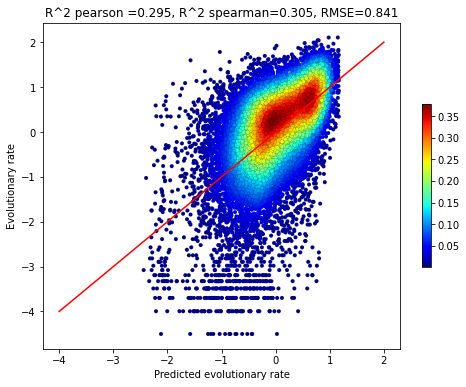

In [10]:
# Fit the classifier to the data
knn = KNeighborsRegressor(best_n_neighbors['n_neighbors'])
y_ = knn.fit(X, y)

# Predict test data
pred_knn = knn.predict(X)

# Calculate correlation
R_p,_ = scipy.stats.pearsonr(pred_knn, y)
R_sp,_ = scipy.stats.spearmanr(pred_knn, y)
RMSE = np.sqrt(np.mean((y-pred_knn)**2))

# Plot empirical vs predicted evolutionary rates
plt.rcParams['figure.figsize'] = [8, 6]
xy = np.vstack([pred_knn, y])
z = gaussian_kde(xy)(xy)
fig, ax = plt.subplots()
plt.scatter(pred_knn, y, c=z, s=15, cmap = 'jet', edgecolors = 'black', linewidths = 0.1)
cb = plt.colorbar(shrink = 0.5)
plt.plot([-4, 2], [-4, 2], 'r')
plt.xlabel('Predicted evolutionary rate')
plt.ylabel('Evolutionary rate')
plt.title("R^2 pearson =%.3f, R^2 spearman=%.3f, RMSE=%.3f" % (R_p**2, R_sp**2, RMSE))
plt.savefig('./figures/knn_fitting.png')


## Ridge regression

In [77]:
# Prepare data
X = torch.tensor(X).float()
y = torch.tensor(y).float()

# Permute the data indexes
np.random.seed(12) # for reproducibility
rand_perm = np.random.permutation(len(y))

# Define training, validation, and test indexes
train_idx = rand_perm[:int(np.ceil(0.8 * len(y)))]
val_idx = rand_perm[int(np.ceil(0.8 * len(y))):int(np.ceil(0.9 * len(y)))]
test_idx = rand_perm[int(np.ceil(0.9 * len(y))):]

# Split data into training, validation and testing
X_train = X[train_idx]
X_val = X[val_idx]
X_test = X[test_idx]

y_train = y[train_idx]
y_val = y[val_idx]
y_test = y[test_idx]

1e-05


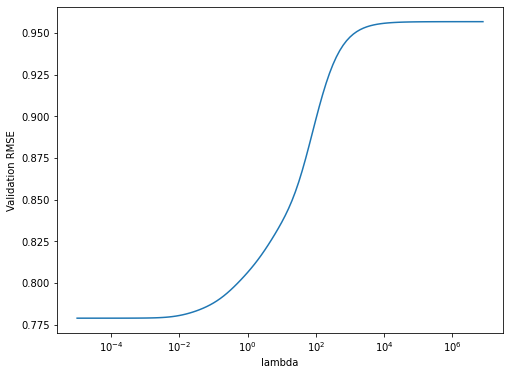

In [12]:
# Find the best alpha
lambdas = 10 ** np.arange(-5, 7, step = 0.1)
val_rmse = []

# Look for the best value of lambda
for a in lambdas:
    ridge = Ridge(normalize=True)
    ridge.set_params(alpha = a)
    ridge.fit(X_train, y_train)
    pred = ridge.predict(X_val)
    val_rmse.append(mean_squared_error(y_val, pred))
    
# Plot
ax = plt.gca()
ax.plot(lambdas, val_rmse)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('lambda')
plt.ylabel('Validation RMSE')
optimal_lamb = lambdas[np.argmin(val_rmse)]
print(optimal_lamb)

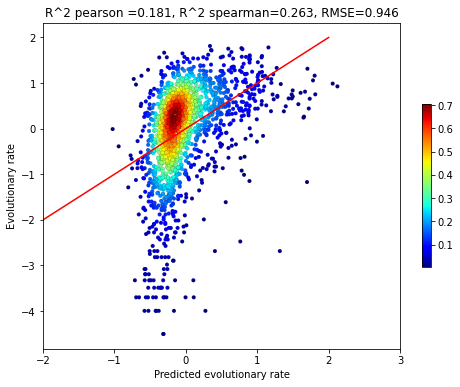

In [13]:
ridge = Ridge(normalize=True)
ridge.set_params(alpha = optimal_lamb)
ridge.fit(X_train, y_train)
pred_rgr = ridge.predict(X_test)
beta = ridge.coef_

# Calculate correlation
R_p,_ = scipy.stats.pearsonr(pred_rgr, y_test)
R_sp,_ = scipy.stats.spearmanr(pred_rgr, y_test)
RMSE = np.sqrt(mean_squared_error(pred_rgr, y_test))

# Plot empirical vs predicted evolutionary rates
plt.rcParams['figure.figsize'] = [8, 6]
xy = np.vstack([pred_rgr, y_test])
z = gaussian_kde(xy)(xy)
fig, ax = plt.subplots()
plt.scatter(pred_rgr, y_test, c=z, s=15, cmap = 'jet', edgecolors = 'black', linewidths = 0.1)
cb = plt.colorbar(shrink = 0.5)
plt.plot([-4, 2], [-4, 2], 'r')
plt.xlim((-2,3))
plt.xlabel('Predicted evolutionary rate')
plt.ylabel('Evolutionary rate')
plt.title("R^2 pearson =%.3f, R^2 spearman=%.3f, RMSE=%.3f" % (R_p**2, R_sp**2, RMSE))
plt.savefig('./figures/ridge_regression.png')

In [14]:
indexes = np.argsort(beta)
d = {'tissue': tissues[indexes], 'weight': beta[indexes]}
df = pd.DataFrame(data=d)
df

,tissue,weight
0,Brain - Frontal Cortex (BA9),-0.459866
1,Brain - Cerebellar Hemisphere,-0.243504
2,Artery - Tibial,-0.176200
3,Muscle - Skeletal,-0.167806
4,Brain - Hypothalamus,-0.152389
5,Cervix - Ectocervix,-0.141785
6,Colon - Sigmoid,-0.116827
7,Esophagus - Gastroesophageal Junction,-0.116038
8,Skin - Not Sun Exposed (Suprapubic),-0.109641
9,Cells - Transformed fibroblasts,-0.101064


## LASSO

1e-06


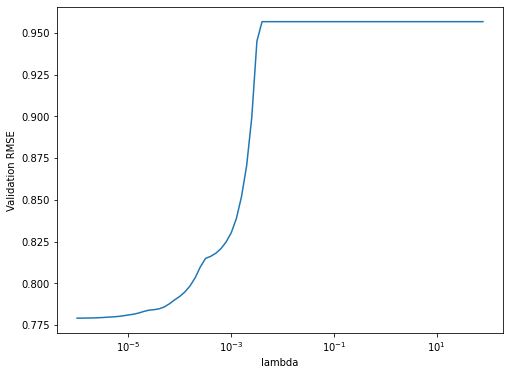

In [15]:
# Find the best alpha
alphas = 10 ** np.arange(-6, 2, step = 0.1)
val_rmse = []

# Look for the best value of lambda
for a in alphas:
    lasso = Lasso(max_iter = 10000, normalize = True)
    lasso.set_params(alpha = a)
    lasso.fit(X_train, y_train)
    pred = lasso.predict(X_val)
    val_rmse.append(mean_squared_error(y_val, pred))
    
# Plot
ax = plt.gca()
ax.plot(alphas, val_rmse)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('lambda')
plt.ylabel('Validation RMSE')
optimal_lamb = alphas[np.argmin(val_rmse)]
print(optimal_lamb)

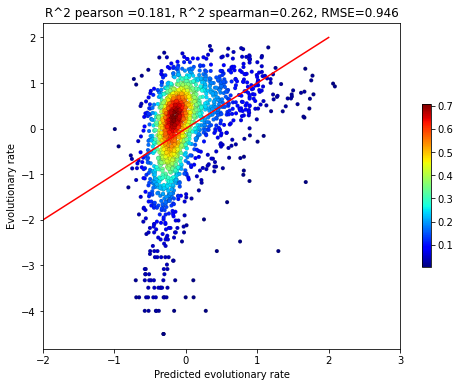

In [59]:
lasso = Lasso(max_iter = 10000, normalize = True)
lasso.set_params(alpha = optimal_lamb)
lasso.fit(X_train, y_train)
pred_lss = lasso.predict(X_test)
beta = lasso.coef_

# Calculate correlation
R_p,_ = scipy.stats.pearsonr(pred_lss, y_test)
R_sp,_ = scipy.stats.spearmanr(pred_lss, y_test)
RMSE = np.sqrt(mean_squared_error(pred_lss, y_test))

# Plot empirical vs predicted evolutionary rates
plt.rcParams['figure.figsize'] = [8, 6]
xy = np.vstack([pred_lss, y_test])
z = gaussian_kde(xy)(xy)
fig, ax = plt.subplots()
plt.scatter(pred_lss, y_test, c=z, s=15, cmap = 'jet', edgecolors = 'black', linewidths = 0.1)
cb = plt.colorbar(shrink = 0.5)
plt.plot([-4, 2], [-4, 2], 'r')
plt.xlim((-2,3))
plt.xlabel('Predicted evolutionary rate')
plt.ylabel('Evolutionary rate')
plt.title("R^2 pearson =%.3f, R^2 spearman=%.3f, RMSE=%.3f" % (R_p**2, R_sp**2, RMSE))
plt.savefig('./figures/lasso_regression.png')


In [49]:
indexes = np.argsort(beta)
d = {'tissue': tissues[indexes], 'weight': beta[indexes]}
df = pd.DataFrame(data=d)
df

,tissue,weight
0,Brain - Frontal Cortex (BA9),-0.451988
1,Brain - Cerebellar Hemisphere,-0.233825
2,Artery - Tibial,-0.170683
3,Muscle - Skeletal,-0.166277
4,Brain - Hypothalamus,-0.149987
5,Cervix - Ectocervix,-0.138920
6,Colon - Sigmoid,-0.116540
7,Esophagus - Gastroesophageal Junction,-0.101306
8,Cells - Transformed fibroblasts,-0.100730
9,Skin - Not Sun Exposed (Suprapubic),-0.097440


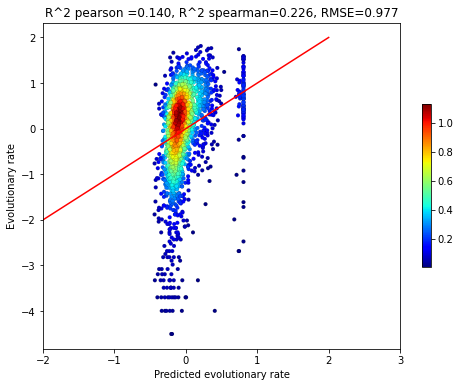

In [71]:
lasso = Lasso(max_iter = 10000, normalize = True)
lasso.set_params(alpha = 0.001) 
lasso.fit(X_train, y_train)
pred_lss = lasso.predict(X_test)
beta = lasso.coef_

# Calculate correlation
R_p,_ = scipy.stats.pearsonr(pred_lss, y_test)
R_sp,_ = scipy.stats.spearmanr(pred_lss, y_test)
RMSE = np.sqrt(mean_squared_error(pred_lss, y_test))

# Plot empirical vs predicted evolutionary rates
plt.rcParams['figure.figsize'] = [8, 6]
xy = np.vstack([pred_lss, y_test])
z = gaussian_kde(xy)(xy)
fig, ax = plt.subplots()
plt.scatter(pred_lss, y_test, c=z, s=15, cmap = 'jet', edgecolors = 'black', linewidths = 0.1)
cb = plt.colorbar(shrink = 0.5)
plt.plot([-4, 2], [-4, 2], 'r')
plt.xlim((-2,3))
plt.xlabel('Predicted evolutionary rate')
plt.ylabel('Evolutionary rate')
plt.title("R^2 pearson =%.3f, R^2 spearman=%.3f, RMSE=%.3f" % (R_p**2, R_sp**2, RMSE))
plt.savefig('./figures/lasso_regression_2.png')


In [72]:
indexes = np.argsort(beta)
d = {'tissue': tissues[indexes], 'weight': beta[indexes]}
df = pd.DataFrame(data=d)
df

,tissue,weight
0,Brain - Frontal Cortex (BA9),-0.233102
1,Brain - Cerebellar Hemisphere,-0.036780
2,Esophagus - Muscularis,-0.000000
3,Fallopian Tube,-0.000000
4,Heart - Atrial Appendage,-0.000000
5,Heart - Left Ventricle,-0.000000
6,Kidney - Cortex,-0.000000
7,Liver,-0.000000
8,Lung,-0.000000
9,Minor Salivary Gland,-0.000000


## Support Vector Regression

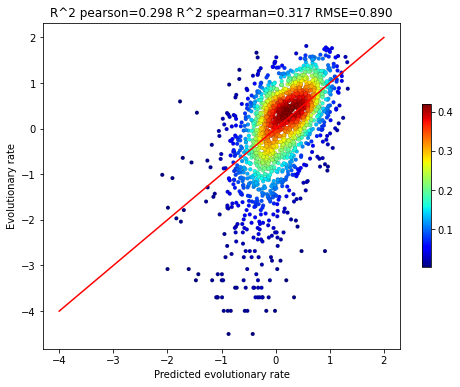

In [80]:
# Support vector regression
svr_model = SVR(kernel = 'rbf')
svr_model.fit(X_train, y_train)

# Prediction
pred_svm = svr_model.predict(X_test)
pred_svm = pred_svm.squeeze()

# Calculate correlation
R_p,_ = scipy.stats.pearsonr(pred_svm, y_test)
R_sp,_ = scipy.stats.spearmanr(pred_svm, y_test)
RMSE = np.sqrt(mean_squared_error(pred_svm, y_test))

# Plot
plt.rcParams['figure.figsize'] = [8, 6]
xy = np.vstack([pred_svm, y_test])
z = gaussian_kde(xy)(xy)
fig, ax = plt.subplots()
plt.scatter(pred_svm, y_test, c=z, s=15, cmap = 'jet', edgecolors = 'black', linewidths = 0.1)
cb = plt.colorbar(shrink = 0.5)
plt.plot([-4, 2], [-4, 2], 'r')
plt.xlabel('Predicted evolutionary rate')
plt.ylabel('Evolutionary rate')
plt.title("R^2 pearson=%.3f R^2 spearman=%.3f RMSE=%.3f" % (R_p**2, R_sp**2, RMSE))
plt.savefig('./figures/svm_prediction.png')

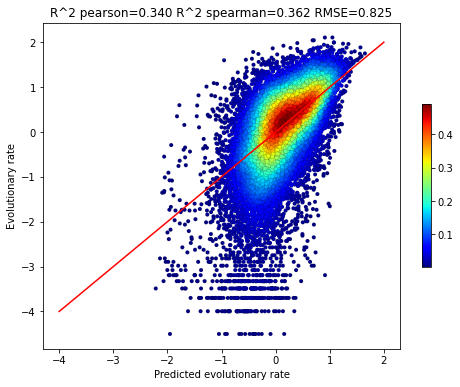

In [81]:
# Support vector regression
svr_model = SVR(kernel = 'rbf')
svr_model.fit(X, y)

# Prediction
pred_svm = svr_model.predict(X)
pred_svm = pred_svm.squeeze()

# Calculate correlation
R_p,_ = scipy.stats.pearsonr(pred_svm, y)
R_sp,_ = scipy.stats.spearmanr(pred_svm, y)
RMSE = np.sqrt(mean_squared_error(pred_svm, y))

# Plot
plt.rcParams['figure.figsize'] = [8, 6]
xy = np.vstack([pred_svm, y])
z = gaussian_kde(xy)(xy)
fig, ax = plt.subplots()
plt.scatter(pred_svm, y, c=z, s=15, cmap = 'jet', edgecolors = 'black', linewidths = 0.1)
cb = plt.colorbar(shrink = 0.5)
plt.plot([-4, 2], [-4, 2], 'r')
plt.xlabel('Predicted evolutionary rate')
plt.ylabel('Evolutionary rate')
plt.title("R^2 pearson=%.3f R^2 spearman=%.3f RMSE=%.3f" % (R_p**2, R_sp**2, RMSE))
plt.savefig('./figures/svm_fitting.png')